# MLP - Top model according to the SCPM of -5.30

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

from sklearn.metrics import r2_score

2024-12-28 21:08:14.038976: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 21:08:14.041113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 21:08:14.086170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-28 21:08:14.087372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-28 21:08:14.910649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=256, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(units=128, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=64, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
REPEAT = 0

<IPython.core.display.Javascript object>

In [5]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [6]:
weights_path = "../../../../models/global_models/209/mlp/s/pre_training/"
model_name = "mlp_full_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [7]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [8]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "209",
    "Plant": "S",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "MLP",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [9]:
df = pd.read_csv("../../../../data/processed/209/s.csv")

<IPython.core.display.Javascript object>

## Defining Features

In [10]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

In [11]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Multi Layer Perceptron

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [12]:
set_seeds()
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
scores_final = None
results_repeats = {}

for repeat in range(repeats):
    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("transformer", StandardScaler()),
            ("estimator", MLP()),
        ]
    )
    cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
    scores = cross_validate(
        pipeline,
        x,
        y,
        scoring=METRICS,
        cv=cv,
        # n_jobs=None,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )
    results_repeats[repeat] = scores

    if scores_final is None:
        scores_final = {key: [] for key, _ in scores.items()}

    for key, value in scores.items():
        scores_final[key] += [value]


print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores_final, METRICS, METRICS_DICT)

scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

2024-12-28 21:08:16.894916: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-28 21:08:16.894975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2024-12-28 21:08:16.894986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2024-12-28 21:08:16.895204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-12-28 21:08:16.895240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-12-28 21:08:16.895248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.467 (0.022)
MAE: -0.356 (0.019)
MAPE: -0.009 (0.000)
R2: 0.992 (0.001)


******
[TEST]
******
RMSE: -0.707 (0.132)
MAE: -0.542 (0.092)
MAPE: -0.013 (0.002)
R2: 0.982 (0.007)


Minutes Elapsed:  4.20819722811381


<IPython.core.display.Javascript object>

In [13]:
def get_predictions_df(scores):
    df_pred = pd.DataFrame()
    df_pred["DATE"] = dates.copy()
    df_pred["CS28"] = y.copy()
    df_pred["CS28_PRED"] = np.nan
    df_pred["SET"] = ""
    df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
    df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

    for idx, pipeline in enumerate(scores["estimator"]):
        index_train = scores["indices"]["train"][idx]
        index_test = scores["indices"]["test"][idx]
        index_preds = np.concatenate([index_train, index_test])

        # results = scores["estimator"][0].predict(x.loc[index_preds])
        results = pipeline.predict(x.loc[index_preds])
        df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
        df_pred.loc[index_train, "SET"] = "TRAIN"
        df_pred.loc[index_test, "SET"] = "TEST"
    df_pred = df_pred.dropna()
    return df_pred

<IPython.core.display.Javascript object>

In [14]:
dfs = []
for repeat in range(repeats):
    scores = results_repeats[repeat]
    df_pred = get_predictions_df(scores)
    df_pred["REPEAT"] = repeat
    dfs.append(df_pred)

df_pred = pd.concat(dfs)

<IPython.core.display.Javascript object>

In [15]:
df_pred = dfs[0]
df_pred["CS28_PRED"] = (
    dfs[0]["CS28_PRED"] + dfs[1]["CS28_PRED"] + dfs[2]["CS28_PRED"]
) / 3

<IPython.core.display.Javascript object>

In [16]:
df_copy_merge = (
    df_copy.reset_index(drop=True)
    .merge(
        df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
    )
    .drop("REPEAT", axis=1)
)

df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
df_copy_merge.to_excel("global_model_mlp_btsscv_209_s.xlsx", index=False)
df_copy_merge.to_csv("global_model_mlp_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [17]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

DATE       CS28  CS28_PRED    SET
0    2021-01-02  34.200001  34.271709  TRAIN
1    2021-01-04  34.700001  35.052464  TRAIN
2    2021-01-04  46.099998  45.138344  TRAIN
3    2021-01-05  45.799999  45.452541  TRAIN
4    2021-01-05  34.599998  34.851990  TRAIN
...         ...        ...        ...    ...
1490 2023-07-15  46.500000  46.059418   TEST
1491 2023-07-18  46.500000  45.699783   TEST
1492 2023-07-18  34.400002  34.903477   TEST
1493 2023-07-19  46.099998  45.678963   TEST
1494 2023-07-19  34.099998  34.953625   TEST

[1495 rows x 4 columns]

<IPython.core.display.Javascript object>

In [18]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

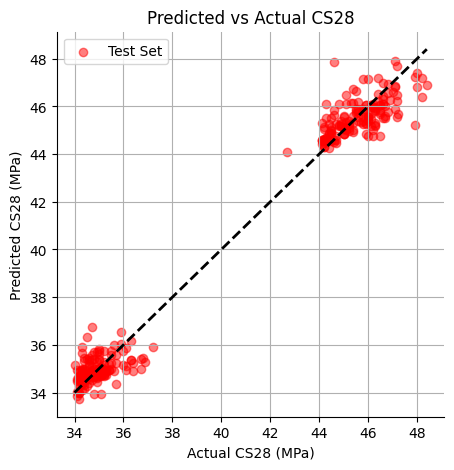

<IPython.core.display.Javascript object>

In [19]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_cs_btiss_fine_tuning_s_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

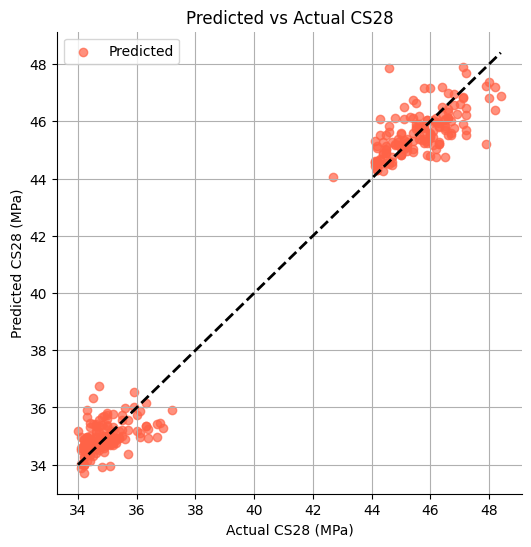

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_global_cm_p_cs_btiss_fine_tuning_s_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [21]:
df["Cement_Type"].value_counts()

Cement_Type
CP II-F-40    749
CP II-Z-32    746
Name: count, dtype: int64

<IPython.core.display.Javascript object>

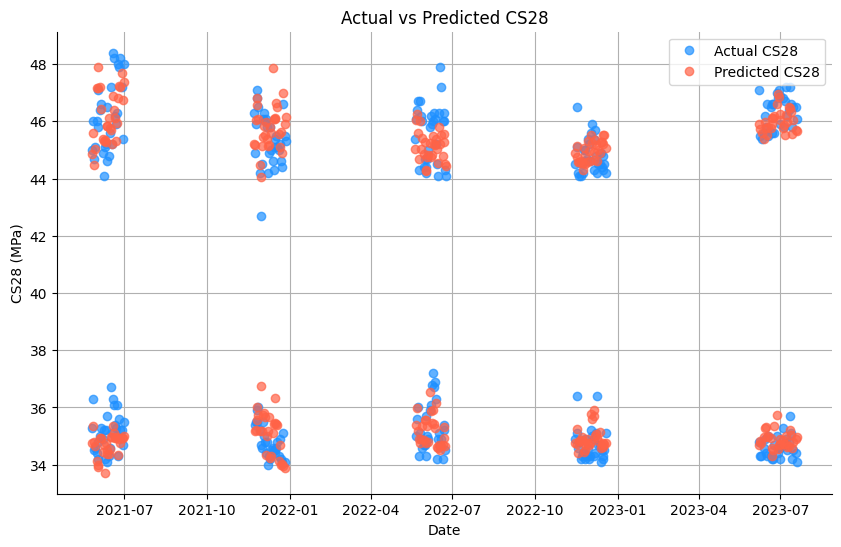

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_cs_btiss_fine_tuning_s_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


/tmp/ipykernel_416797/2174210531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]


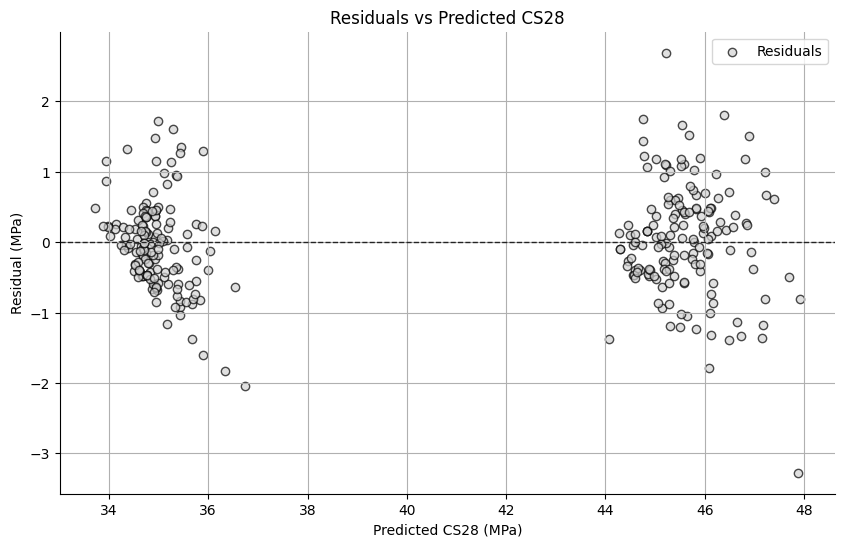

<IPython.core.display.Javascript object>

In [23]:
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_s_fine_tuning_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


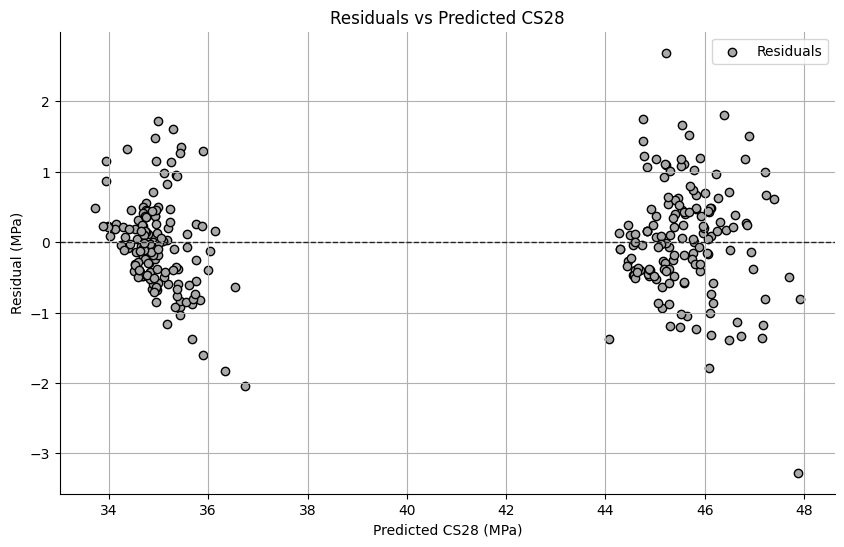

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_p_cs_btiss_top_one_s_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

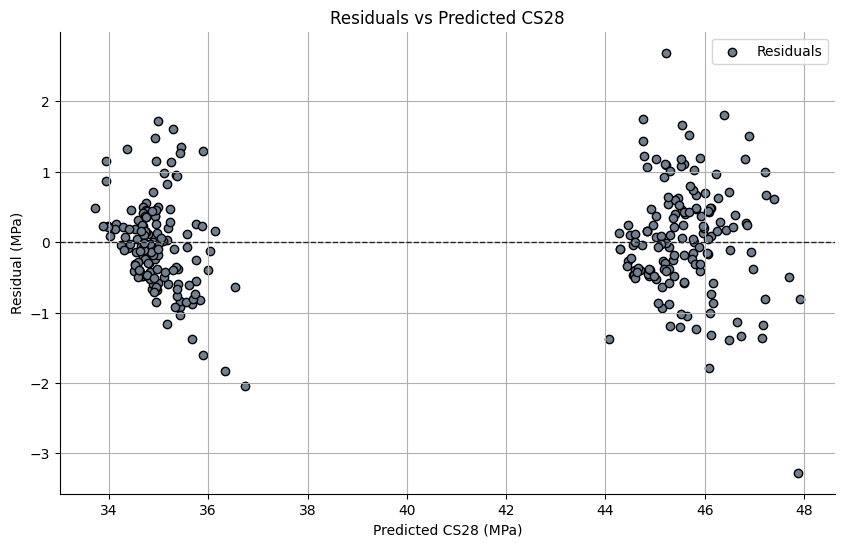

<IPython.core.display.Javascript object>

In [25]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_p_cs_btiss_top_one_s_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

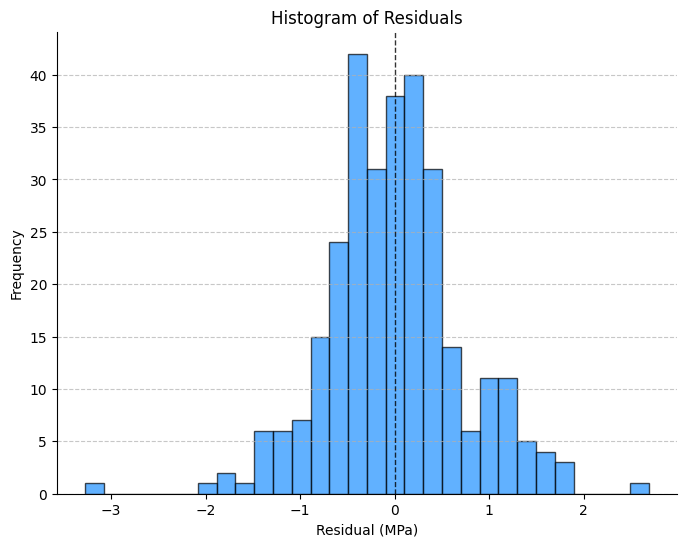

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_p_cs_btiss_dominant_top_one_s_fine_tuning_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Assessing Feature Importance

In [27]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [28]:
perm_importances = []

for repeat in range(repeats):
    scores = results_repeats[repeat]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_index = indices["test"]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_indexes = indices["test"]

    for i, (pipeline, test_idx) in tqdm(enumerate(zip(estimators, test_indexes))):
        result = permutation_importance(
            pipeline,
            x.iloc[test_idx],
            y[test_idx],
            n_repeats=10,
            random_state=SEED,
            n_jobs=1,
            scoring="r2",
        )
        perm_importances.append(result.importances_mean)

5it [00:44,  8.96s/it]
5it [00:44,  8.97s/it]
5it [00:45,  9.01s/it]


<IPython.core.display.Javascript object>

In [29]:
# Average importances across folds
mean_importances = np.mean(perm_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(perm_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [30]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [31]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
    "Loss on Ignition": "LOI",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

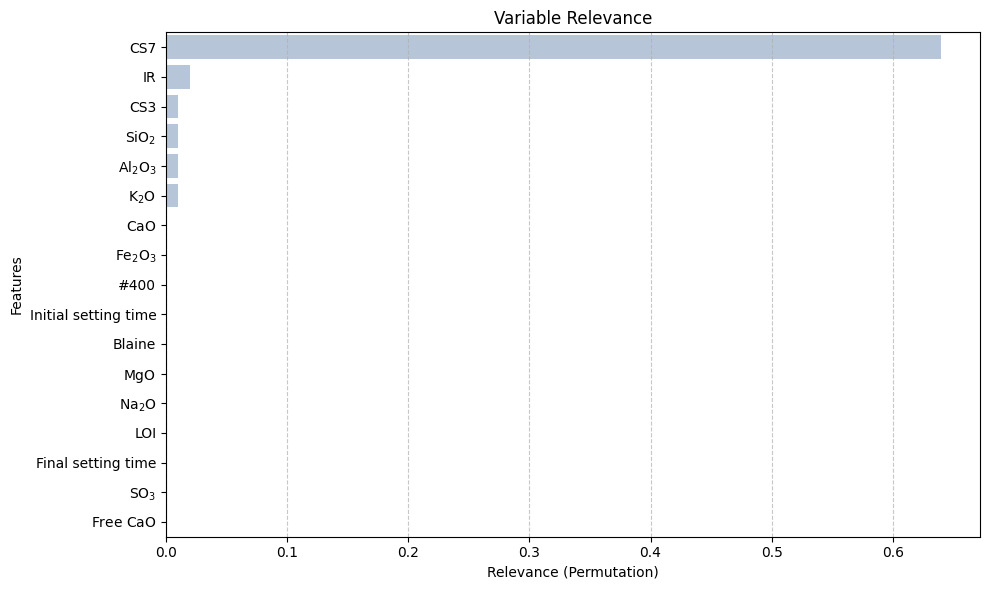

<IPython.core.display.Javascript object>

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


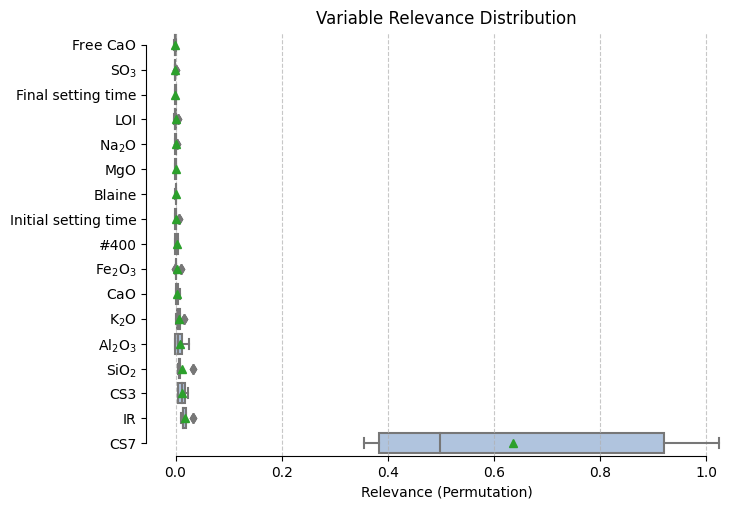

<IPython.core.display.Javascript object>

In [33]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_cs_btiss_fine_tuning_s_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [34]:
df_importances = perm_importances_df

<IPython.core.display.Javascript object>

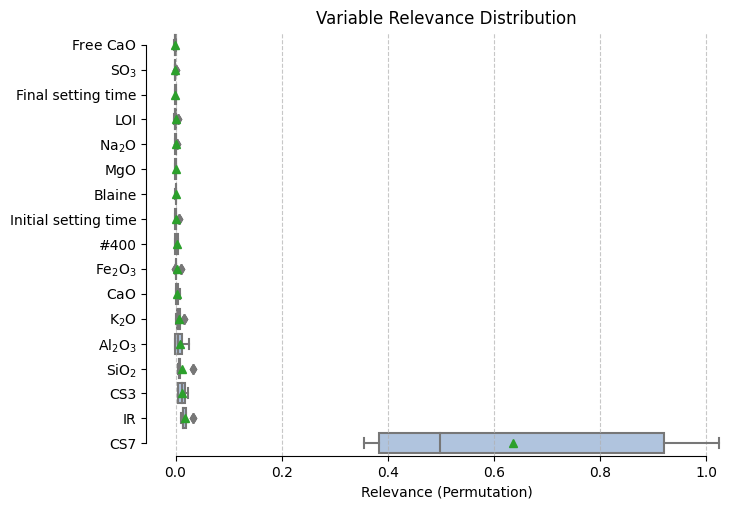

<IPython.core.display.Javascript object>

In [35]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_global_cm_p_cs_btiss_fine_tuning_s_mlp_scpm_best_dist_var_perm_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


In [36]:
df_importances

Free $\mathrm{CaO}$  $\mathrm{SO_3}$  Final setting time       LOI  \
0             -0.000141        -0.000300           -0.000741 -0.001377   
1             -0.003388        -0.000135            0.000688 -0.002970   
2              0.000263        -0.000515            0.000452  0.004693   
3             -0.001261        -0.000390            0.000013 -0.000022   
4              0.000383         0.000550           -0.000919 -0.000302   
5             -0.000141        -0.000300           -0.000741 -0.001377   
6             -0.003388        -0.000135            0.000688 -0.002970   
7              0.000263        -0.000515            0.000452  0.004693   
8             -0.001261        -0.000390            0.000013 -0.000022   
9              0.000383         0.000550           -0.000919 -0.000302   
10            -0.000141        -0.000300           -0.000741 -0.001377   
11            -0.003388        -0.000135            0.000688 -0.002970   
12             0.000263        -0.000515            0.000452  0.004693   
13            -0.001261        -0.000390            0.000013 -0.000022   
14             0.000383         0.000550           -0.000919 -0.000302   

    $\mathrm{Na_2O}$  $\mathrm{MgO}$    Blaine  Initial setting time  \
0          -0.000041       -0.000479  0.000155              0.001710   
1          -0.001588        0.001022  0.001357              0.005715   
2           0.000411        0.000799  0.001424             -0.000781   
3           0.002249       -0.000313  0.000050              0.000616   
4          -0.000764        0.001287 -0.000302             -0.000307   
5          -0.000041       -0.000479  0.000155              0.001710   
6          -0.001588        0.001022  0.001357              0.005715   
7           0.000411        0.000799  0.001424             -0.000781   
8           0.002249       -0.000313  0.000050              0.000616   
9          -0.000764        0.001287 -0.000302             -0.000307   
10         -0.000041       -0.000479  0.000155              0.001710   
11         -0.001588        0.001022  0.001357              0.005715   
12          0.000411        0.000799  0.001424             -0.000781   
13          0.002249       -0.000313  0.000050              0.000616   
14         -0.000764        0.001287 -0.000302             -0.000307   

        #400  $\mathrm{Fe_2O_3}$  $\mathrm{CaO}$  $\mathrm{K_2O}$  \
0   0.005144            0.000492        0.004152         0.002883   
1  -0.001781            0.009908        0.002403         0.007715   
2   0.002264            0.000708        0.000365         0.016150   
3   0.004858            0.000550        0.008454         0.001200   
4  -0.000594           -0.000095        0.000152         0.006428   
5   0.005144            0.000492        0.004152         0.002883   
6  -0.001781            0.009908        0.002403         0.007715   
7   0.002264            0.000708        0.000365         0.016150   
8   0.004858            0.000550        0.008454         0.001200   
9  -0.000594           -0.000095        0.000152         0.006428   
10  0.005144            0.000492        0.004152         0.002883   
11 -0.001781            0.009908        0.002403         0.007715   
12  0.002264            0.000708        0.000365         0.016150   
13  0.004858            0.000550        0.008454         0.001200   
14 -0.000594           -0.000095        0.000152         0.006428   

    $\mathrm{Al_2O_3}$  $\mathrm{SiO_2}$       CS3        IR       CS7  
0             0.012990          0.006337  0.003767  0.010696  0.384099  
1             0.025091          0.008681  0.022865  0.014928  1.024161  
2             0.005313          0.003923  0.018510  0.032708  0.497259  
3            -0.000538          0.032974  0.005021  0.019047  0.354877  
4            -0.000916          0.006754  0.012325  0.013593  0.920183  
5             0.012990          0.006337  0.003767  0.010696  0.384099  
6             0.025091          0.008681  0.022865

<IPython.core.display.Javascript object>

In [37]:
df_importances.describe().T

count      mean       std       min       25%       50%  \
Free $\mathrm{CaO}$    15.0 -0.000829  0.001454 -0.003388 -0.001261 -0.000141   
$\mathrm{SO_3}$        15.0 -0.000158  0.000388 -0.000515 -0.000390 -0.000300   
Final setting time     15.0 -0.000101  0.000658 -0.000919 -0.000741  0.000013   
LOI                    15.0  0.000004  0.002652 -0.002970 -0.001377 -0.000302   
$\mathrm{Na_2O}$       15.0  0.000053  0.001335 -0.001588 -0.000764 -0.000041   
$\mathrm{MgO}$         15.0  0.000463  0.000745 -0.000479 -0.000313  0.000799   
Blaine                 15.0  0.000537  0.000738 -0.000302  0.000050  0.000155   
Initial setting time   15.0  0.001391  0.002405 -0.000781 -0.000307  0.000616   
#400                   15.0  0.001978  0.002896 -0.001781 -0.000594  0.002264   
$\mathrm{Fe_2O_3}$     15.0  0.002312  0.003941 -0.000095  0.000492  0.000550   
$\mathrm{CaO}$         15.0  0.003105  0.003154  0.000152  0.000365  0.002403   
$\mathrm{K_2O}$        15.0  0.006875  0.005380  0.001200  0.002883  0.006428   
$\mathrm{Al_2O_3}$     15.0  0.008388  0.010098 -0.000916 -0.000538  0.005313   
$\mathrm{SiO_2}$       15.0  0.011734  0.011104  0.003923  0.006337  0.006754   
CS3                    15.0  0.012498  0.007687  0.003767  0.005021  0.012325   
IR                     15.0  0.018194  0.008010  0.010696  0.013593  0.014928   
CS7                    15.0  0.636116  0.290257  0.354877  0.384099  0.497259   

                           75%       max  
Free $\mathrm{CaO}$   0.000263  0.000383  
$\mathrm{SO_3}$      -0.000135  0.000550  
Final setting time    0.000452  0.000688  
LOI                  -0.000022  0.004693  
$\mathrm{Na_2O}$      0.000411  0.002249  
$\mathrm{MgO}$        0.001022  0.001287  
Blaine                0.001357  0.001424  
Initial setting time  0.001710  0.005715  
#400                  0.004858  0.005144  
$\mathrm{Fe_2O_3}$    0.000708  0.009908  
$\mathrm{CaO}$        0.004152  0.008454  
$\mathrm{K_2O}$       0.007715  0.016150  
$\mathrm{Al_2O_3}$    0.012990  0.025091  
$\mathrm{SiO_2}$      0.008681  0.032974  
CS3                   0.018510  0.022865  
IR                    0.019047  0.032708  
CS7                   0.920183  1.024161

<IPython.core.display.Javascript object>

# Analysis of predictions on the Global Dataset

*The model is the same. However We'll show the predictions of it on the global dataset*

## Reading the dataset

In [38]:
df = pd.read_csv("../../../../data/processed/209/global_s.csv")

<IPython.core.display.Javascript object>

## Defining the features

In [39]:
df_copy = df.copy().drop(
    [
        "Factory_Plant",
        "Cement_Type",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [40]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [41]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split
        self.num_features = x.shape[-1]
        dummy_input_shape = (
            self.batch_size,
            self.num_features,
        )
        self.model.build(dummy_input_shape)

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=256, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(units=128, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=64, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [42]:
weights_path = "../../../../models/global_models/209/mlp/s/pre_training/"
model_name = "mlp_s_full_vars_weights_partial_ds_weights.h5"

full_path = os.path.join(weights_path, model_name)

# Split train test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

test_index = x_test.index
dates_test = df[["Date"]].iloc[test_index]

imputer = SimpleImputer(strategy="median")
transformer = StandardScaler()

x_train = transformer.fit_transform(imputer.fit_transform(x_train))
x_test = transformer.transform(imputer.transform(x_test))

model = MLP()
model.load_pretrained_weights()

# Make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.361 (0.000)
MAE: 1.031 (0.000)
MAPE: 0.023 (0.000)
R2: 0.960 (0.000)


******
[TEST]
******
RMSE: 1.466 (0.000)
MAE: 1.091 (0.000)
MAPE: 0.026 (0.000)
R2: 0.940 (0.000)




<IPython.core.display.Javascript object>

In [43]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

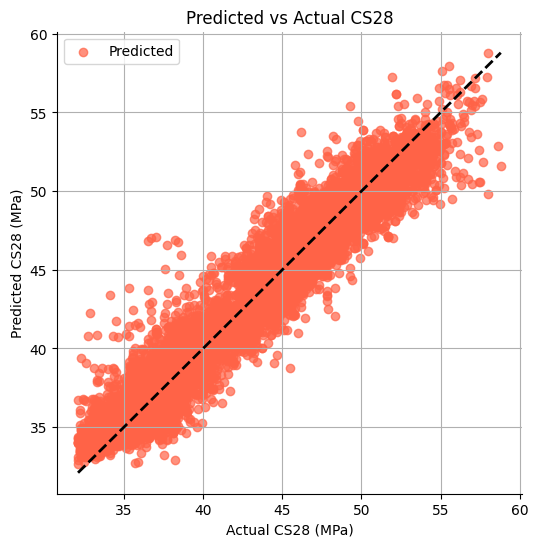

<IPython.core.display.Javascript object>

In [44]:
test_data = pd.DataFrame(
    {
        "DATE": dates_test.values.squeeze(),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)
test_data = test_data[test_data["CS28"] > 32]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_s_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

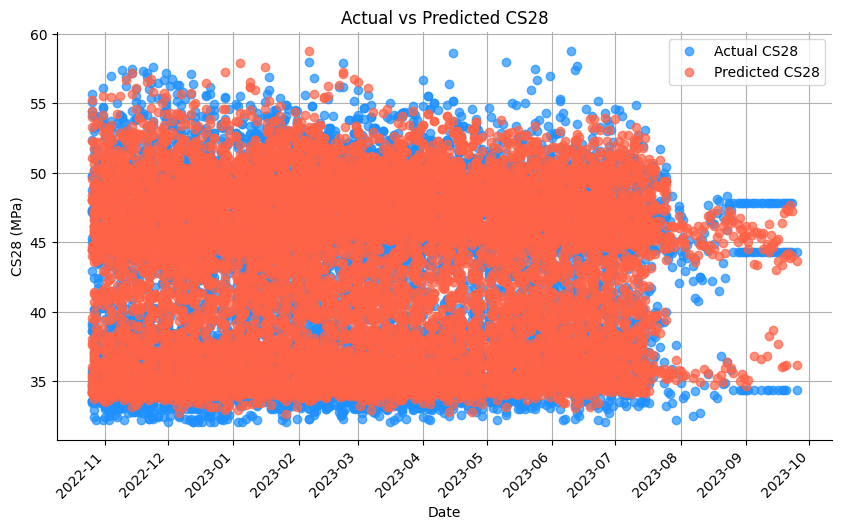

<IPython.core.display.Javascript object>

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert dates to datetime if they aren't already
test_data = pd.DataFrame(
    {
        "DATE": pd.to_datetime(dates_test["Date"]),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)

test_data = test_data[test_data["CS28"] > 32]


plt.figure(figsize=(10, 6))

# Add vertical line exactly at the start of test data first (so it's behind the points)
# test_start_date = test_data["DATE"].iloc[0]  # Get the exact first date of test data
# plt.axvline(x=test_start_date, color="gray", linestyle="--", alpha=0.5)


# Plot actual test data
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
    markersize=6,
)

# Plot test predictions
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
    markersize=6,
)

plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
# plt.title("Actual CS28 (Full Series) vs Predicted CS28 (Test Period)")
plt.title("Actual vs Predicted CS28")

plt.legend()
plt.grid(True)

# Improving x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_s_dominant_pred_vs_actual_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

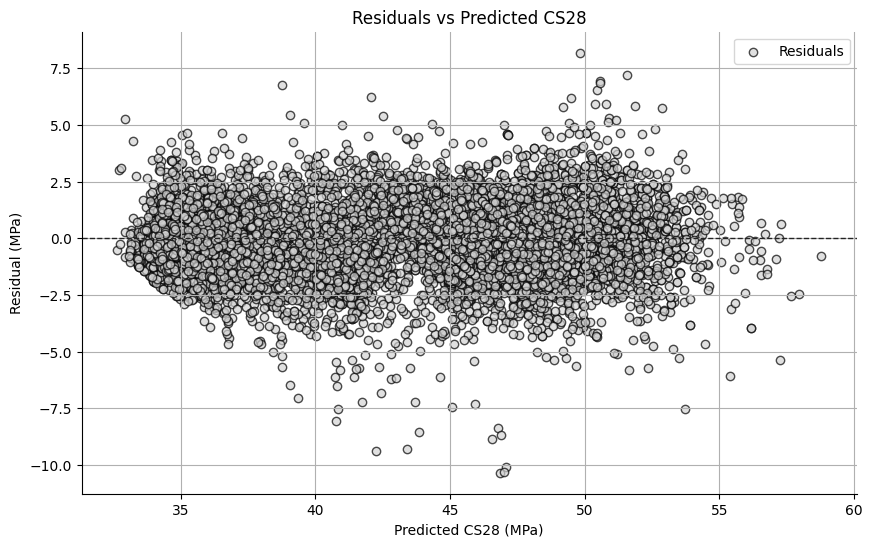

<IPython.core.display.Javascript object>

In [46]:
# Calculate residuals
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_pre_train_s_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


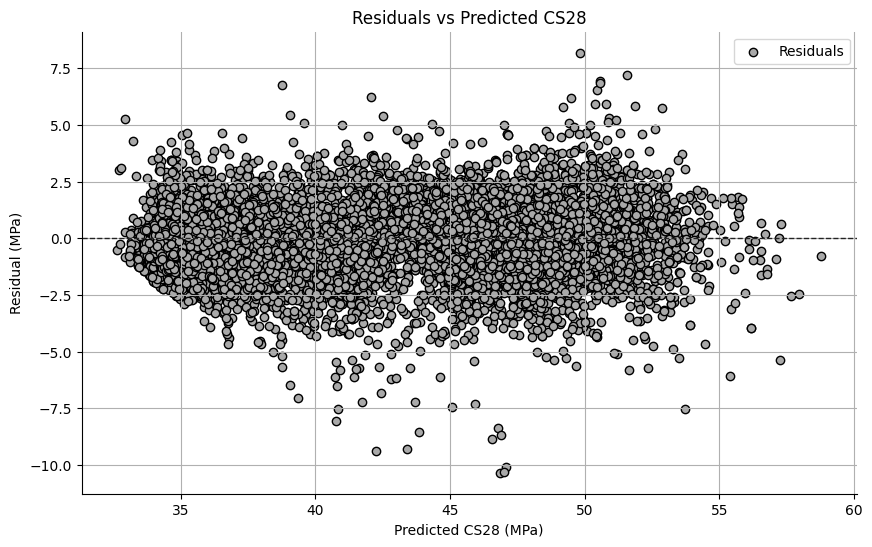

<IPython.core.display.Javascript object>

In [47]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_pre_train_s_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

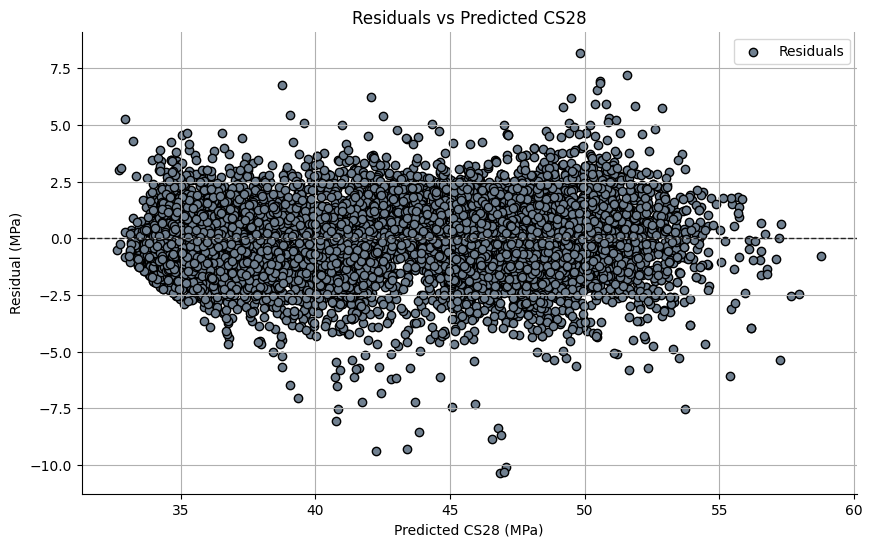

<IPython.core.display.Javascript object>

In [48]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_pre_train_s_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

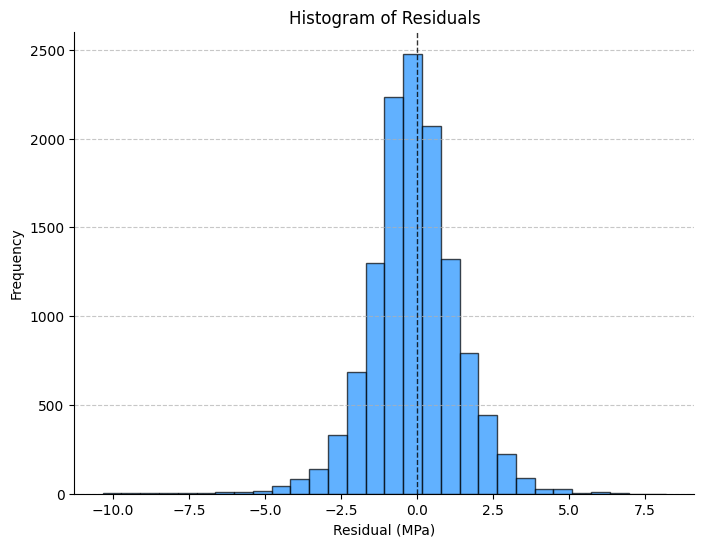

<IPython.core.display.Javascript object>

In [49]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_p_cs_btiss_dominant_top_one_pre_train_s_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [50]:
def permutation_importance_distribution(model, X, y, metric, n_repeats=10):
    """
    Computes permutation importance for sequence models with 3D input,
    returning the distribution of importance scores across repetitions.
    """
    baseline_score = metric(y, model.predict(X))  # Compute baseline metric
    num_features = X.shape[1]  # Number of features
    importances = np.zeros(
        (num_features, n_repeats)
    )  # Store all scores for distribution
    set_seeds()  # Ensure reproducibility if necessary

    for i in range(num_features):
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across all samples
            feature_values = X_permuted[:, i]
            np.random.shuffle(feature_values)
            X_permuted[:, i] = feature_values

            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            # Store the importance score for this repetition
            importances[i, repeat] = baseline_score - permuted_score

    return importances

<IPython.core.display.Javascript object>

In [51]:
# Compute permutation importance
feature_importances = []
# importances = permutation_importance_seq(model, x_test, y_test, r2_score, n_repeats=10)
importances = permutation_importance_distribution(
    model, x_test, y_test, r2_score, n_repeats=10
)
feature_importances.append(importances)
# feature_importances = feature_importances[0].T
feature_importances = importances.T

<IPython.core.display.Javascript object>

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns

# Average importances across folds
# mean_importances = np.mean(feature_importances.T, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

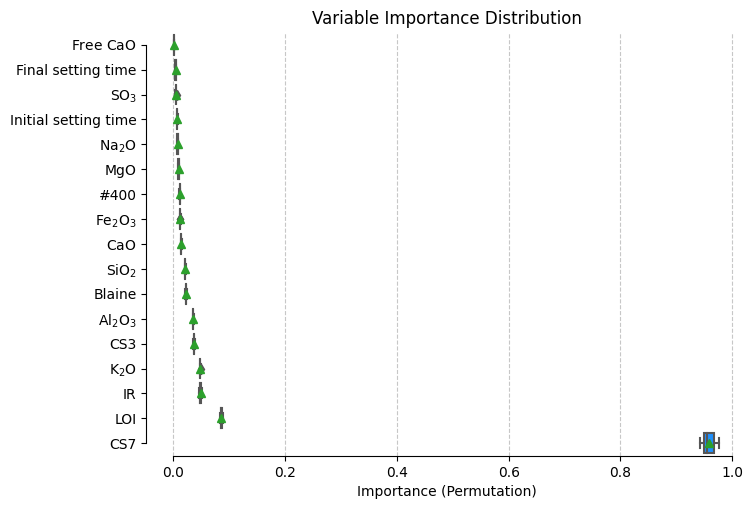

<IPython.core.display.Javascript object>

In [53]:
import matplotlib

perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="dodgerblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_s_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

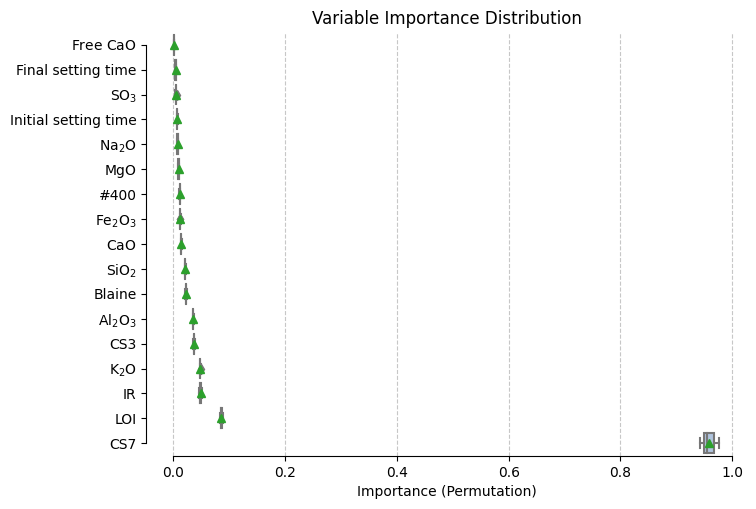

<IPython.core.display.Javascript object>

In [54]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_s_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [55]:
perm_importances_df_plot

Free $\mathrm{CaO}$  Final setting time  $\mathrm{SO_3}$  \
0             0.001291            0.004086         0.003902   
1             0.001058            0.003808         0.004653   
2             0.001213            0.003993         0.004913   
3             0.001139            0.004073         0.003900   
4             0.001045            0.004146         0.004536   
5             0.000976            0.004072         0.005907   
6             0.000837            0.003795         0.004206   
7             0.001393            0.004404         0.004259   
8             0.001163            0.004260         0.004726   
9             0.001342            0.003773         0.003430   

   Initial setting time  $\mathrm{Na_2O}$  $\mathrm{MgO}$      #400  \
0              0.006003          0.008502        0.009366  0.011376   
1              0.006536          0.007615        0.009324  0.011143   
2              0.006855          0.007614        0.009211  0.011143   
3              0.007317          0.008051        0.009959  0.012137   
4              0.007087          0.007849        0.009597  0.011834   
5              0.007675          0.007078        0.009049  0.010604   
6              0.006168          0.007737        0.009545  0.011298   
7              0.007138          0.007677        0.009466  0.011337   
8              0.007067          0.007237        0.009682  0.012155   
9              0.006700          0.007016        0.009146  0.011175   

   $\mathrm{Fe_2O_3}$  $\mathrm{CaO}$  $\mathrm{SiO_2}$    Blaine  \
0            0.013035        0.013119          0.020844  0.023349   
1            0.012846        0.014587          0.021109  0.022426   
2            0.011950        0.013909          0.021224  0.024217   
3            0.012045        0.014555          0.022004  0.022281   
4            0.012602        0.013534          0.021110  0.022780   
5            0.012680        0.013839          0.021261  0.021604   
6            0.013276        0.014946          0.021686  0.022875   
7            0.012902        0.014532          0.021601  0.023441   
8            0.012722        0.013981          0.021725  0.022409   
9            0.012916        0.013487          0.021186  0.021948   

   $\mathrm{Al_2O_3}$       CS3  $\mathrm{K_2O}$        IR       LOI       CS7  
0            0.037157  0.036293         0.049210  0.048134  0.086579  0.951530  
1            0.034885  0.037544         0.048376  0.046290  0.084868  0.976718  
2            0.034821  0.035045         0.048664  0.051238  0.084593  0.957084  
3            0.035438  0.036335         0.048014  0.048539  0.087341  0.953611  
4            0.034869  0.036909         0.049767  0.050765  0.085084  0.969363  
5            0.034569  0.034732         0.047534  0.047686  0.088858  0.948394  
6            0.036553  0.036424         0.048629  0.051621  0.086759  0.945458  
7            0.036192  0.038557         0.047609  0.046507  0.085788  0.970489  
8            0.035822  0.037710         0.048035  0.047948  0.086657  0.942806  
9            0.035693  0.036551         0.048343  0.048883  0.082853  0.962616

<IPython.core.display.Javascript object>

In [56]:
perm_importances_df_plot.describe().T

count      mean       std       min       25%       50%  \
Free $\mathrm{CaO}$    10.0  0.001146  0.000172  0.000837  0.001048  0.001151   
Final setting time     10.0  0.004041  0.000206  0.003773  0.003854  0.004072   
$\mathrm{SO_3}$        10.0  0.004443  0.000683  0.003430  0.003978  0.004397   
Initial setting time   10.0  0.006855  0.000515  0.006003  0.006577  0.006961   
$\mathrm{Na_2O}$       10.0  0.007638  0.000451  0.007016  0.007331  0.007646   
$\mathrm{MgO}$         10.0  0.009435  0.000274  0.009049  0.009239  0.009416   
#400                   10.0  0.011420  0.000486  0.010604  0.011151  0.011317   
$\mathrm{Fe_2O_3}$     10.0  0.012697  0.000416  0.011950  0.012621  0.012784   
$\mathrm{CaO}$         10.0  0.014049  0.000587  0.013119  0.013610  0.013945   
$\mathrm{SiO_2}$       10.0  0.021375  0.000359  0.020844  0.021129  0.021242   
Blaine                 10.0  0.022733  0.000775  0.021604  0.022313  0.022603   
$\mathrm{Al_2O_3}$     10.0  0.035600  0.000849  0.034569  0.034873  0.035566   
CS3                    10.0  0.036610  0.001162  0.034732  0.036304  0.036487   
$\mathrm{K_2O}$        10.0  0.048418  0.000692  0.047534  0.048019  0.048359   
IR                     10.0  0.048761  0.001879  0.046290  0.047752  0.048336   
LOI                    10.0  0.085938  0.001677  0.082853  0.084922  0.086183   
CS7                    10.0  0.957807  0.011541  0.942806  0.949178  0.955348   

                           75%       max  
Free $\mathrm{CaO}$   0.001272  0.001393  
Final setting time    0.004131  0.004404  
$\mathrm{SO_3}$       0.004708  0.005907  
Initial setting time  0.007125  0.007675  
$\mathrm{Na_2O}$      0.007821  0.008502  
$\mathrm{MgO}$        0.009584  0.009959  
#400                  0.011720  0.012155  
$\mathrm{Fe_2O_3}$    0.012912  0.013276  
$\mathrm{CaO}$        0.014549  0.014946  
$\mathrm{SiO_2}$      0.021664  0.022004  
Blaine                0.023231  0.024217  
$\mathrm{Al_2O_3}$    0.036099  0.037157  
CS3                   0.037385  0.038557  
$\mathrm{K_2O}$       0.048655  0.049767  
IR                    0.050295  0.051621  
LOI                   0.086733  0.088858  
CS7                   0.967676  0.976718

<IPython.core.display.Javascript object>

# Plant K

### MLP - Top model according to the SCPM of -5.71

# Functions and definitions

In [57]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=256, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(units=128, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=64, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [58]:
SEED = 47
REPEAT = 0

<IPython.core.display.Javascript object>

In [59]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [60]:
weights_path = "../../../../models/global_models/209/mlp/k/pre_training/"
model_name = "mlp_full_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [61]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [62]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "209",
    "Plant": "K",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "MLP",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [63]:
df = pd.read_csv("../../../../data/processed/209/k.csv")

<IPython.core.display.Javascript object>

## Defining Features

In [64]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

In [65]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Multi Layer Perceptron

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [66]:
set_seeds()
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
scores_final = None
results_repeats = {}

for repeat in range(repeats):
    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("transformer", StandardScaler()),
            ("estimator", MLP()),
        ]
    )
    cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
    scores = cross_validate(
        pipeline,
        x,
        y,
        scoring=METRICS,
        cv=cv,
        # n_jobs=None,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )
    results_repeats[repeat] = scores

    if scores_final is None:
        scores_final = {key: [] for key, _ in scores.items()}

    for key, value in scores.items():
        scores_final[key] += [value]


print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores_final, METRICS, METRICS_DICT)

scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.551 (0.060)
MAE: -0.420 (0.048)
MAPE: -0.010 (0.001)
R2: 0.992 (0.002)


******
[TEST]
******
RMSE: -0.857 (0.216)
MAE: -0.673 (0.157)
MAPE: -0.016 (0.004)
R2: 0.973 (0.019)


Minutes Elapsed:  9.044023148218791


<IPython.core.display.Javascript object>

In [67]:
def get_predictions_df(scores):
    df_pred = pd.DataFrame()
    df_pred["DATE"] = dates.copy()
    df_pred["CS28"] = y.copy()
    df_pred["CS28_PRED"] = np.nan
    df_pred["SET"] = ""
    df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
    df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

    for idx, pipeline in enumerate(scores["estimator"]):
        index_train = scores["indices"]["train"][idx]
        index_test = scores["indices"]["test"][idx]
        index_preds = np.concatenate([index_train, index_test])

        # results = scores["estimator"][0].predict(x.loc[index_preds])
        results = pipeline.predict(x.loc[index_preds])
        df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
        df_pred.loc[index_train, "SET"] = "TRAIN"
        df_pred.loc[index_test, "SET"] = "TEST"
    df_pred = df_pred.dropna()
    return df_pred

<IPython.core.display.Javascript object>

In [68]:
dfs = []
for repeat in range(repeats):
    scores = results_repeats[repeat]
    df_pred = get_predictions_df(scores)
    df_pred["REPEAT"] = repeat
    dfs.append(df_pred)

df_pred = pd.concat(dfs)

<IPython.core.display.Javascript object>

In [69]:
df_pred = dfs[0]
df_pred["CS28_PRED"] = (
    dfs[0]["CS28_PRED"] + dfs[1]["CS28_PRED"] + dfs[2]["CS28_PRED"]
) / 3

<IPython.core.display.Javascript object>

In [70]:
df_copy_merge = (
    df_copy.reset_index(drop=True)
    .merge(
        df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
    )
    .drop("REPEAT", axis=1)
)

df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
df_copy_merge.to_excel("global_model_mlp_btsscv_209_k.xlsx", index=False)
df_copy_merge.to_csv("global_model_mlp_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [71]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

DATE       CS28  CS28_PRED    SET
0    2021-01-02  38.900002  38.736530  TRAIN
1    2021-01-04  48.500000  48.531364  TRAIN
2    2021-01-04  36.500000  36.829170  TRAIN
3    2021-01-04  36.299999  36.816551  TRAIN
4    2021-01-04  55.599998  55.541290  TRAIN
...         ...        ...        ...    ...
3340 2023-07-17  46.200001  46.042934   TEST
3341 2023-07-18  44.700001  45.725098   TEST
3342 2023-07-19  45.700001  46.898460   TEST
3343 2023-07-20  47.799999  47.460644   TEST
3344 2023-07-21  44.500000  46.429661   TEST

[3345 rows x 4 columns]

<IPython.core.display.Javascript object>

In [72]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

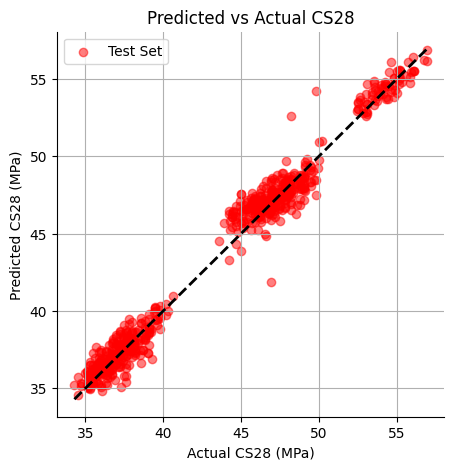

<IPython.core.display.Javascript object>

In [73]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_cs_btiss_fine_tuning_k_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

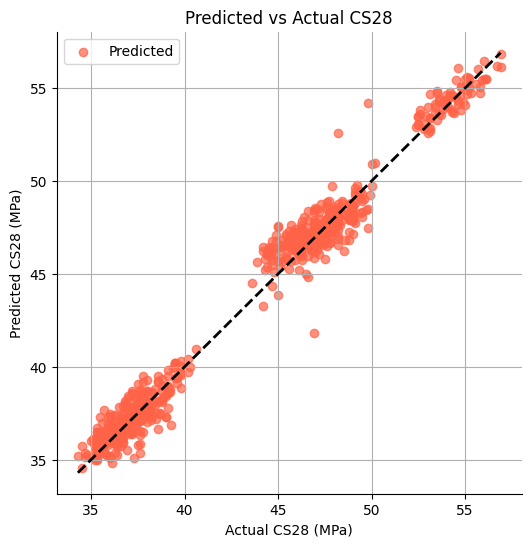

<IPython.core.display.Javascript object>

In [74]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_global_cm_p_cs_btiss_fine_tuning_k_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [75]:
df["Cement_Type"].value_counts()

Cement_Type
CP II-F-40    1526
CP II-F-32     718
CP IV-32       661
CP V-ARI       440
Name: count, dtype: int64

<IPython.core.display.Javascript object>

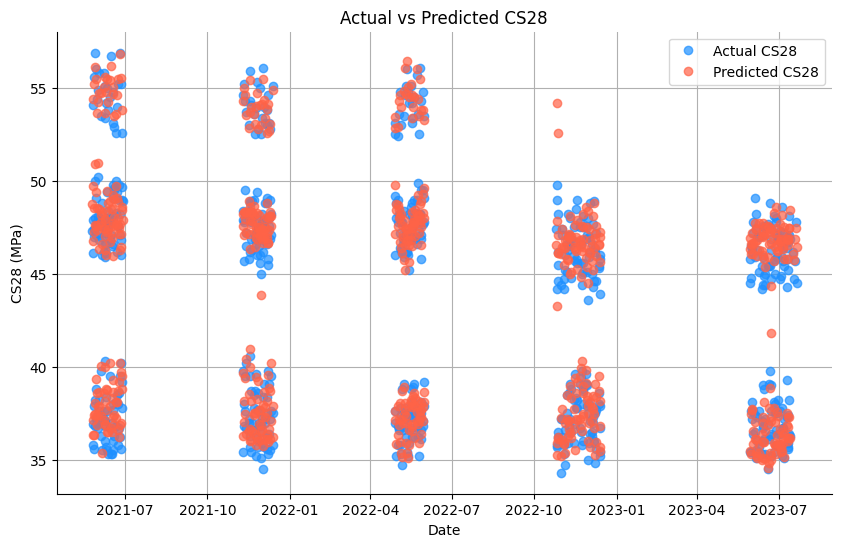

<IPython.core.display.Javascript object>

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_cm_p_cs_btiss_fine_tuning_k_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


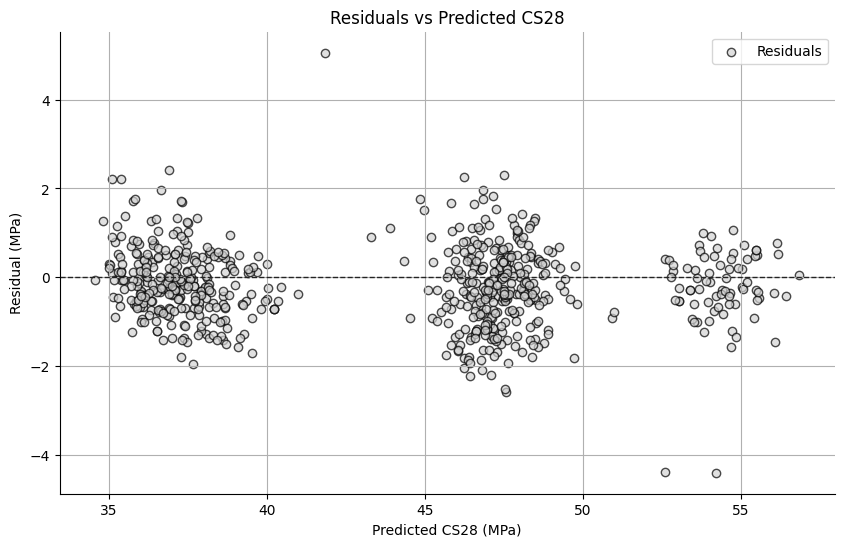

<IPython.core.display.Javascript object>

In [77]:
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_k_fine_tuning_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


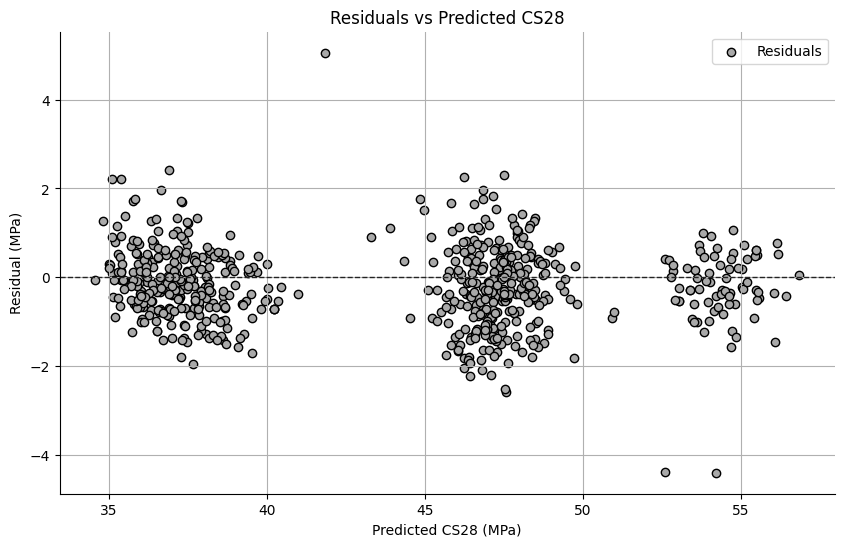

<IPython.core.display.Javascript object>

In [78]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_p_cs_btiss_top_one_k_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

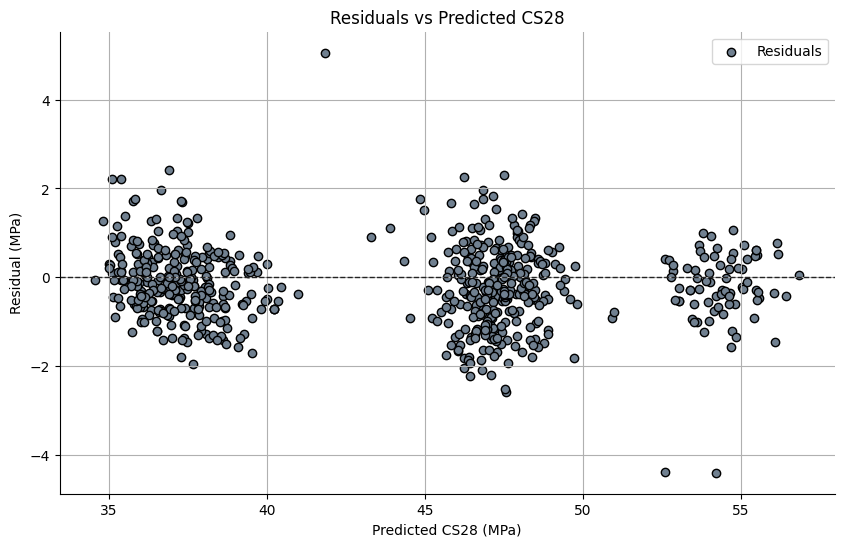

<IPython.core.display.Javascript object>

In [79]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
# plt.savefig(
#     "ecics_global_cm_p_cs_btiss_top_one_k_fine_tuning_residuals_vs_predicted.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()

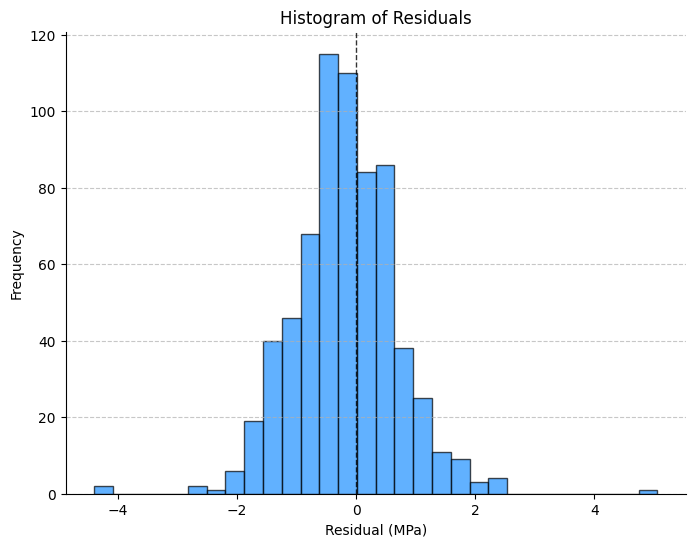

<IPython.core.display.Javascript object>

In [80]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_p_cs_btiss_dominant_top_one_k_fine_tuning_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Assessing Feature Importance

In [81]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [82]:
perm_importances = []

for repeat in range(repeats):
    scores = results_repeats[repeat]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_index = indices["test"]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_indexes = indices["test"]

    for i, (pipeline, test_idx) in tqdm(enumerate(zip(estimators, test_indexes))):
        result = permutation_importance(
            pipeline,
            x.iloc[test_idx],
            y[test_idx],
            n_repeats=10,
            random_state=SEED,
            n_jobs=1,
            scoring="r2",
        )
        perm_importances.append(result.importances_mean)

5it [00:45,  9.14s/it]
5it [00:45,  9.18s/it]
5it [00:45,  9.07s/it]


<IPython.core.display.Javascript object>

In [83]:
# Average importances across folds
mean_importances = np.mean(perm_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(perm_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [84]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [85]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
    "Loss on Ignition": "LOI",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

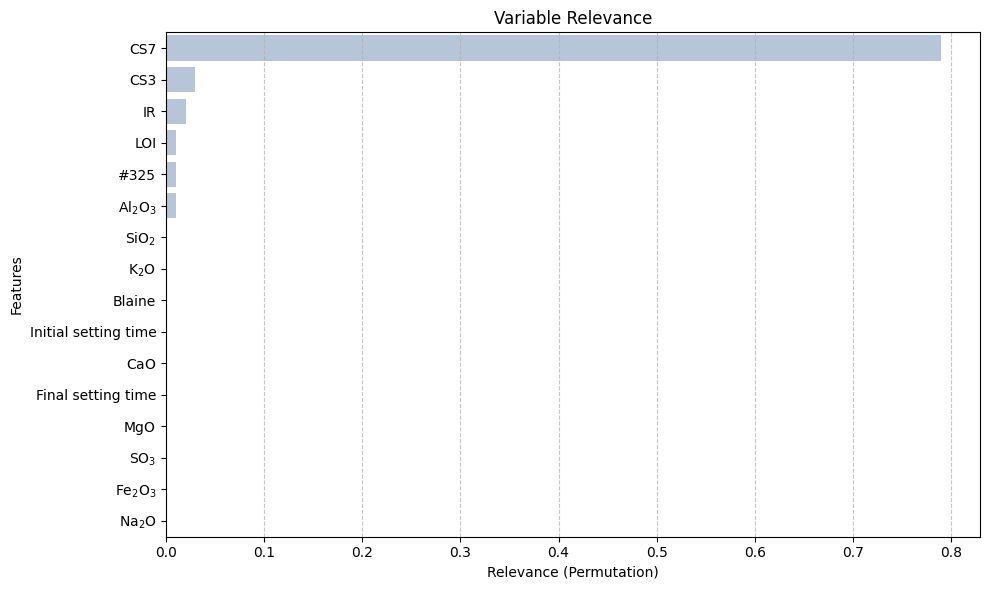

<IPython.core.display.Javascript object>

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


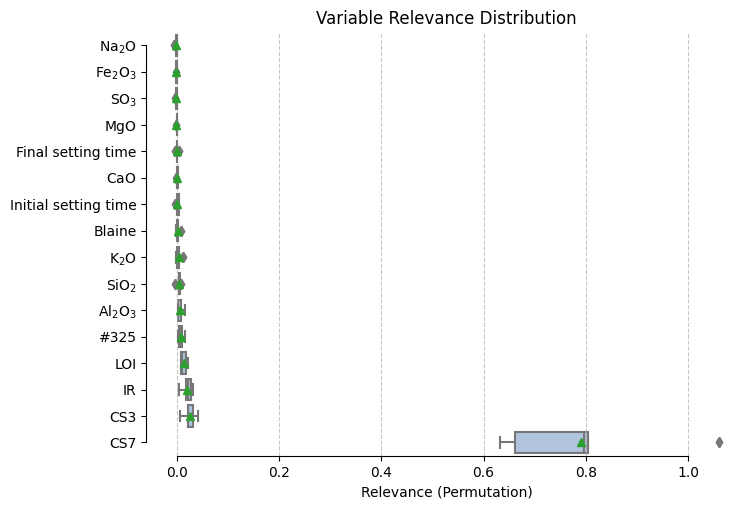

<IPython.core.display.Javascript object>

In [87]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_cs_btiss_fine_tuning_k_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [88]:
df_importances = perm_importances_df

<IPython.core.display.Javascript object>

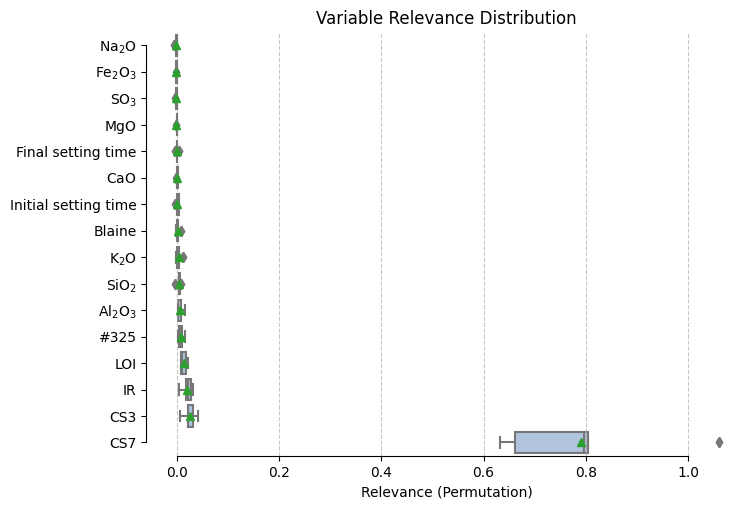

<IPython.core.display.Javascript object>

In [89]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_global_cm_p_cs_btiss_fine_tuning_k_mlp_scpm_best_dist_var_perm_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


In [90]:
df_importances

$\mathrm{Na_2O}$  $\mathrm{Fe_2O_3}$  $\mathrm{SO_3}$  $\mathrm{MgO}$  \
0          -0.000658           -0.000267        -0.000530        0.000417   
1           0.001213           -0.000149         0.000606       -0.000140   
2           0.000916            0.000294         0.000475        0.000092   
3           0.000656           -0.001287        -0.002335        0.000081   
4          -0.005666           -0.000521         0.000029       -0.001908   
5          -0.000658           -0.000267        -0.000530        0.000417   
6           0.001213           -0.000149         0.000606       -0.000140   
7           0.000916            0.000294         0.000475        0.000092   
8           0.000656           -0.001287        -0.002335        0.000081   
9          -0.005666           -0.000521         0.000029       -0.001908   
10         -0.000658           -0.000267        -0.000530        0.000417   
11          0.001213           -0.000149         0.000606       -0.000140   
12          0.000916            0.000294         0.000475        0.000092   
13          0.000656           -0.001287        -0.002335        0.000081   
14         -0.005666           -0.000521         0.000029       -0.001908   

    Final setting time  $\mathrm{CaO}$  Initial setting time    Blaine  \
0             0.000046        0.002283              0.003921  0.000889   
1             0.000964        0.003042              0.001999 -0.000430   
2             0.000496        0.001227              0.000961  0.002839   
3            -0.002948        0.000849              0.003970  0.002631   
4             0.003820       -0.001719             -0.003925  0.009479   
5             0.000046        0.002283              0.003921  0.000889   
6             0.000964        0.003042              0.001999 -0.000430   
7             0.000496        0.001227              0.000961  0.002839   
8            -0.002948        0.000849              0.003970  0.002631   
9             0.003820       -0.001719             -0.003925  0.009479   
10            0.000046        0.002283              0.003921  0.000889   
11            0.000964        0.003042              0.001999 -0.000430   
12            0.000496        0.001227              0.000961  0.002839   
13           -0.002948        0.000849              0.003970  0.002631   
14            0.003820       -0.001719             -0.003925  0.009479   

    $\mathrm{K_2O}$  $\mathrm{SiO_2}$  $\mathrm{Al_2O_3}$      #325       LOI  \
0          0.012553          0.004821            0.008182  0.016113  0.018730   
1          0.005346          0.005622            0.001989  0.011130  0.009370   
2          0.001197          0.004080            0.001956  0.003881  0.009938   
3         -0.000737          0.008839            0.016185  0.006023  0.022419   
4          0.002202         -0.002325            0.008804  0.003463  0.008457   
5          0.012553          0.004821            0.008182  0.016113  0.018730   
6          0.005346          0.005622            0.001989  0.011130  0.009370   
7          0.001197          0.004080            0.001956  0.003881  0.009938   
8         -0.000737          0.008839            0.016185  0.006023  0.022419   
9          0.002202         -0.002325            0.008804  0.003463  0.008457   
10         0.012553          0.004821            0.008182  0.016113  0.018730   
11         0.005346          0.005622            0.001989  0.011130  0.009370   
12         0.001197          0.004080            0.001956  0.003881  0.009938   
13        -0.000737          0.008839            0.016185  0.006023  0.022419   
14         0.002202         -0.002325            0.008804  0.003463  0.008457   

          IR       CS3       CS7  
0   0.021556  0.022169  0.661101  
1   0.028654  0.023093  0.803408  
2   0.032297  0.032740  0.632854  
3   0.018398  0.042111  0.795594  
4   0.004812  0.007212  1.060728  
5   0.021556  0.022169  0.661101  
6   0.028654  0.023093  0.803408  
7   0.032

<IPython.core.display.Javascript object>

In [91]:
df_importances.describe().T

count      mean       std       min       25%       50%  \
$\mathrm{Na_2O}$       15.0 -0.000708  0.002650 -0.005666 -0.000658  0.000656   
$\mathrm{Fe_2O_3}$     15.0 -0.000386  0.000540 -0.001287 -0.000521 -0.000267   
$\mathrm{SO_3}$        15.0 -0.000351  0.001106 -0.002335 -0.000530  0.000029   
$\mathrm{MgO}$         15.0 -0.000292  0.000856 -0.001908 -0.000140  0.000081   
Final setting time     15.0  0.000476  0.002236 -0.002948  0.000046  0.000496   
$\mathrm{CaO}$         15.0  0.001136  0.001681 -0.001719  0.000849  0.001227   
Initial setting time   15.0  0.001385  0.002995 -0.003925  0.000961  0.001999   
Blaine                 15.0  0.003082  0.003535 -0.000430  0.000889  0.002631   
$\mathrm{K_2O}$        15.0  0.004112  0.004820 -0.000737  0.001197  0.002202   
$\mathrm{SiO_2}$       15.0  0.004207  0.003776 -0.002325  0.004080  0.004821   
$\mathrm{Al_2O_3}$     15.0  0.007423  0.005451  0.001956  0.001989  0.008182   
#325                   15.0  0.008122  0.005007  0.003463  0.003881  0.006023   
LOI                    15.0  0.013783  0.005886  0.008457  0.009370  0.009938   
IR                     15.0  0.021144  0.009877  0.004812  0.018398  0.021556   
CS3                    15.0  0.025465  0.012069  0.007212  0.022169  0.023093   
CS7                    15.0  0.790737  0.156852  0.632854  0.661101  0.795594   

                           75%       max  
$\mathrm{Na_2O}$      0.000916  0.001213  
$\mathrm{Fe_2O_3}$   -0.000149  0.000294  
$\mathrm{SO_3}$       0.000475  0.000606  
$\mathrm{MgO}$        0.000092  0.000417  
Final setting time    0.000964  0.003820  
$\mathrm{CaO}$        0.002283  0.003042  
Initial setting time  0.003921  0.003970  
Blaine                0.002839  0.009479  
$\mathrm{K_2O}$       0.005346  0.012553  
$\mathrm{SiO_2}$      0.005622  0.008839  
$\mathrm{Al_2O_3}$    0.008804  0.016185  
#325                  0.011130  0.016113  
LOI                   0.018730  0.022419  
IR                    0.028654  0.032297  
CS3                   0.032740  0.042111  
CS7                   0.803408  1.060728

<IPython.core.display.Javascript object>

# Analysis of predictions on the Global Dataset

*The model is the same. However We'll show the predictions of it on the global dataset*

## Reading the dataset

In [92]:
df = pd.read_csv("../../../../data/processed/209/global_k.csv")

<IPython.core.display.Javascript object>

## Defining the features

In [93]:
df_copy = df.copy().drop(
    [
        "Factory_Plant",
        "Cement_Type",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [94]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [95]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split
        self.num_features = x.shape[-1]
        dummy_input_shape = (
            self.batch_size,
            self.num_features,
        )
        self.model.build(dummy_input_shape)

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=256, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(units=128, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=64, activation="elu")),
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [96]:
weights_path = "../../../../models/global_models/209/mlp/k/pre_training/"
model_name = "mlp_k_full_vars_weights_partial_ds_weights.h5"

full_path = os.path.join(weights_path, model_name)

# Split train test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

test_index = x_test.index
dates_test = df[["Date"]].iloc[test_index]

imputer = SimpleImputer(strategy="median")
transformer = StandardScaler()

x_train = transformer.fit_transform(imputer.fit_transform(x_train))
x_test = transformer.transform(imputer.transform(x_test))

model = MLP()
model.load_pretrained_weights()

# Make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.408 (0.000)
MAE: 1.063 (0.000)
MAPE: 0.024 (0.000)
R2: 0.958 (0.000)


******
[TEST]
******
RMSE: 1.505 (0.000)
MAE: 1.117 (0.000)
MAPE: 0.026 (0.000)
R2: 0.938 (0.000)




<IPython.core.display.Javascript object>

In [97]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

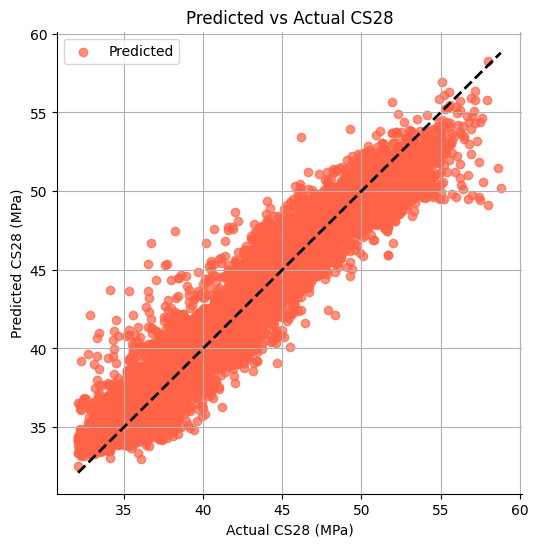

<IPython.core.display.Javascript object>

In [98]:
test_data = pd.DataFrame(
    {
        "DATE": dates_test.values.squeeze(),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)
test_data = test_data[test_data["CS28"] > 32]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_global_pre_train_k_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

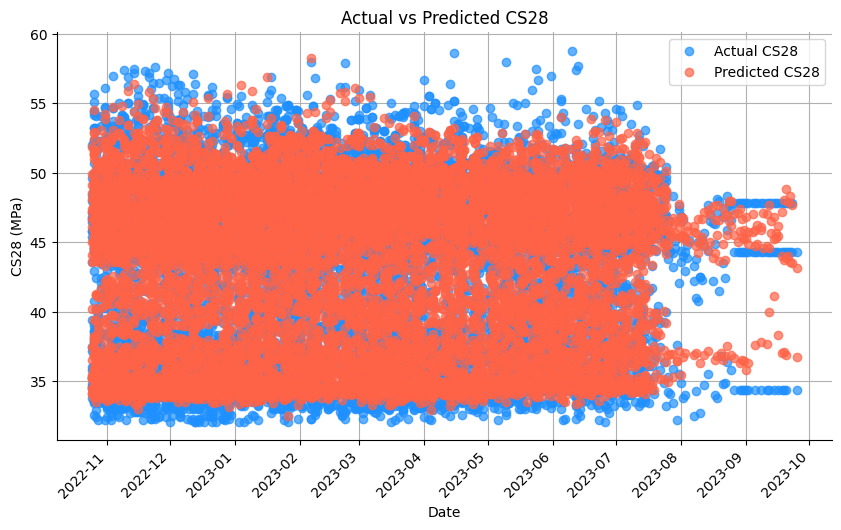

<IPython.core.display.Javascript object>

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert dates to datetime if they aren't already
test_data = pd.DataFrame(
    {
        "DATE": pd.to_datetime(dates_test["Date"]),
        "CS28": y_test,
        "CS28_PRED": y_test_pred.squeeze(),
    }
)

test_data = test_data[test_data["CS28"] > 32]


plt.figure(figsize=(10, 6))

# Add vertical line exactly at the start of test data first (so it's behind the points)
# test_start_date = test_data["DATE"].iloc[0]  # Get the exact first date of test data
# plt.axvline(x=test_start_date, color="gray", linestyle="--", alpha=0.5)


# Plot actual test data
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
    markersize=6,
)

# Plot test predictions
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
    markersize=6,
)

plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
# plt.title("Actual CS28 (Full Series) vs Predicted CS28 (Test Period)")
plt.title("Actual vs Predicted CS28")

plt.legend()
plt.grid(True)

# Improving x-axis readability with 2-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gcf().autofmt_xdate(rotation=45)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_k_dominant_pred_vs_actual_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

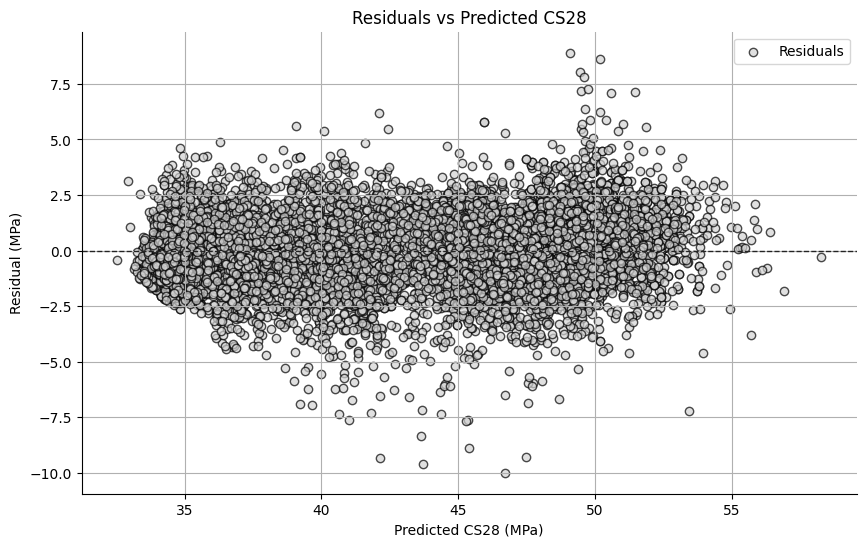

<IPython.core.display.Javascript object>

In [100]:
# Calculate residuals
test_data["RESIDUAL"] = test_data["CS28"] - test_data["CS28_PRED"]

plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="lightgray",
    alpha=0.7,
    edgecolor="black",
    label="Residuals"
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_pre_train_k_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


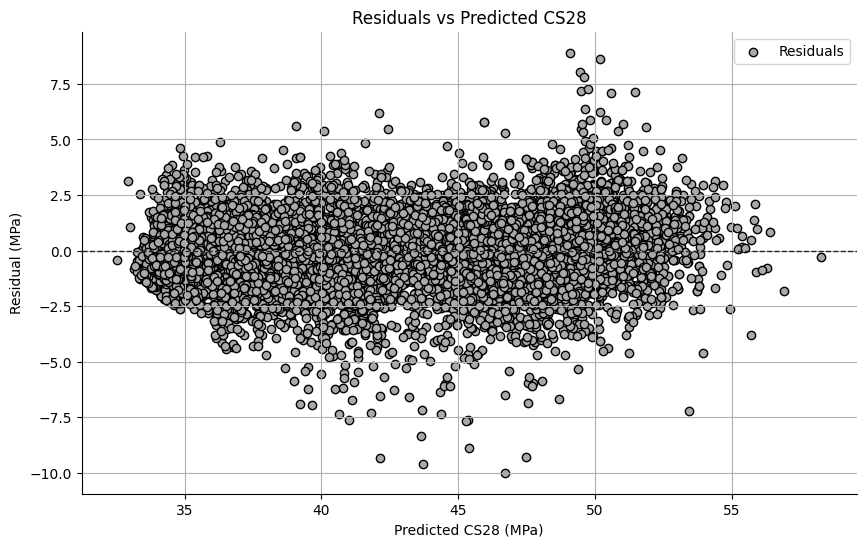

<IPython.core.display.Javascript object>

In [101]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="darkgray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_pre_train_k_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

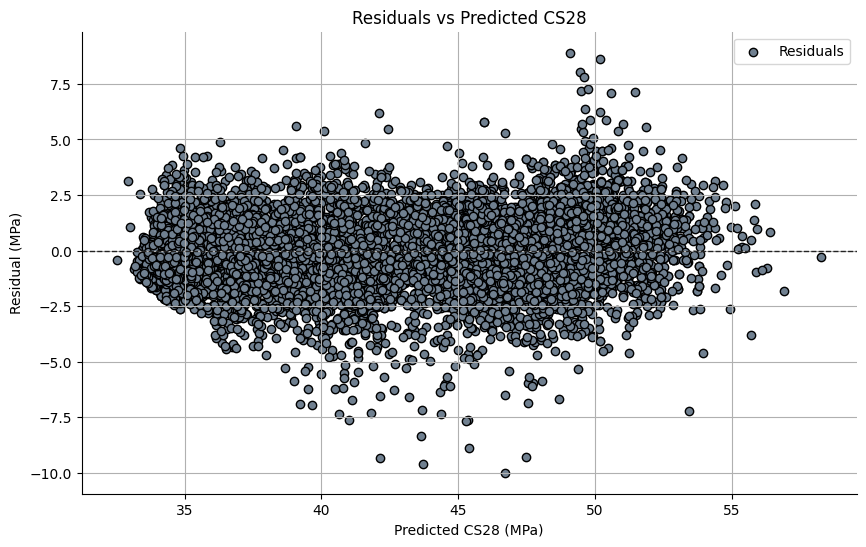

<IPython.core.display.Javascript object>

In [102]:
plt.figure(figsize=(10, 6))

# Plot residuals vs predicted values
plt.scatter(
    test_data["CS28_PRED"],
    test_data["RESIDUAL"],
    color="slategray",
    alpha=1,
    edgecolor="black",
    label="Residuals",
)

# Add horizontal line at zero for reference
plt.axhline(y=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

plt.xlabel("Predicted CS28 (MPa)")
plt.ylabel("Residual (MPa)")
plt.title("Residuals vs Predicted CS28")
plt.legend()
plt.grid(True)

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the figure
plt.savefig(
    "ecics_global_cm_p_cs_btiss_top_one_pre_train_k_residuals_vs_predicted.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

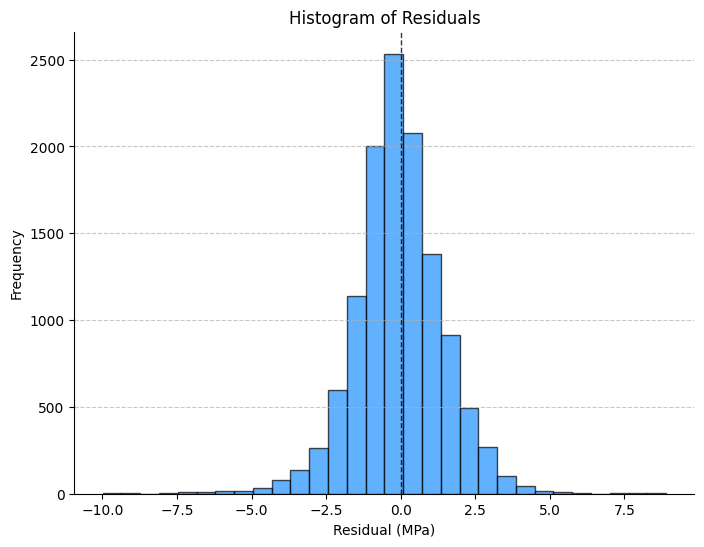

<IPython.core.display.Javascript object>

In [103]:
plt.figure(figsize=(8, 6))

# Plot histogram of residuals
plt.hist(
    test_data["RESIDUAL"],
    bins=30,  # Number of bins for better granularity
    color="dodgerblue",
    edgecolor="black",
    alpha=0.7
)

# Add labels and title
plt.xlabel("Residual (MPa)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# Add a vertical line at 0 for reference
plt.axvline(x=0, color="black", linestyle="--", linewidth=1, alpha=0.8)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Remove top and right spines for cleaner aesthetics
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Save the plot
plt.savefig(
    "ecics_global_cm_p_cs_btiss_dominant_top_one_pre_train_k_residual_histogram.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [104]:
def permutation_importance_distribution(model, X, y, metric, n_repeats=10):
    """
    Computes permutation importance for sequence models with 3D input,
    returning the distribution of importance scores across repetitions.
    """
    baseline_score = metric(y, model.predict(X))  # Compute baseline metric
    num_features = X.shape[1]  # Number of features
    importances = np.zeros(
        (num_features, n_repeats)
    )  # Store all scores for distribution
    set_seeds()  # Ensure reproducibility if necessary

    for i in range(num_features):
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across all samples
            feature_values = X_permuted[:, i]
            np.random.shuffle(feature_values)
            X_permuted[:, i] = feature_values

            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            # Store the importance score for this repetition
            importances[i, repeat] = baseline_score - permuted_score

    return importances

<IPython.core.display.Javascript object>

In [105]:
# Compute permutation importance
feature_importances = []
# importances = permutation_importance_seq(model, x_test, y_test, r2_score, n_repeats=10)
importances = permutation_importance_distribution(
    model, x_test, y_test, r2_score, n_repeats=10
)
feature_importances.append(importances)
# feature_importances = feature_importances[0].T
feature_importances = importances.T

<IPython.core.display.Javascript object>

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns

# Average importances across folds
# mean_importances = np.mean(feature_importances.T, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

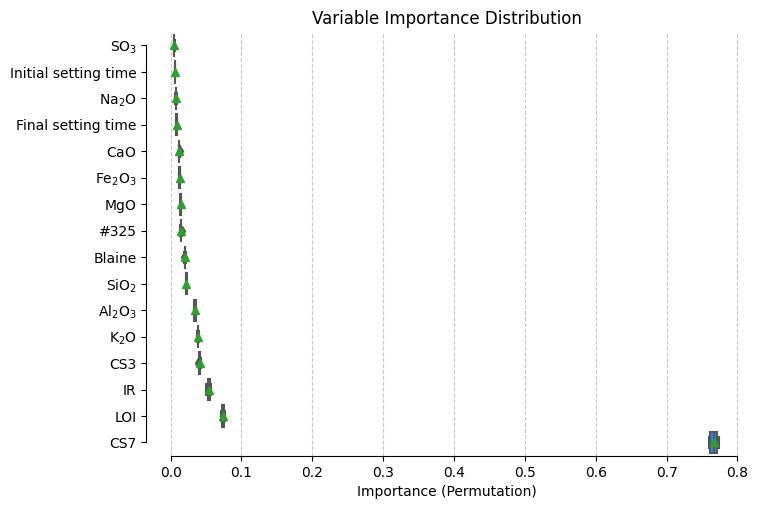

<IPython.core.display.Javascript object>

In [107]:
import matplotlib

perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="dodgerblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_k_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

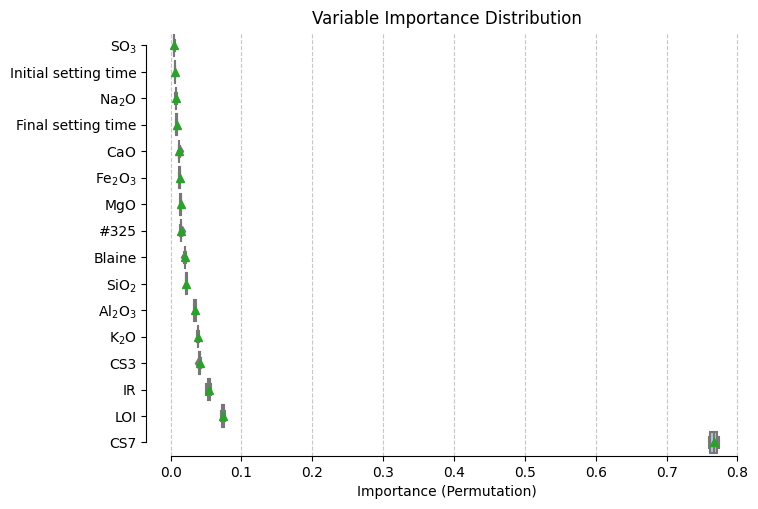

<IPython.core.display.Javascript object>

In [108]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_global_cm_p_cs_btiss_pre_train_k_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [109]:
perm_importances_df_plot

$\mathrm{SO_3}$  Initial setting time  $\mathrm{Na_2O}$  \
0         0.004623              0.006738          0.006918   
1         0.004457              0.005882          0.008264   
2         0.004712              0.006300          0.008324   
3         0.005269              0.006856          0.007812   
4         0.004699              0.005960          0.008598   
5         0.005666              0.006014          0.008161   
6         0.004620              0.006527          0.007143   
7         0.005465              0.006827          0.007576   
8         0.004671              0.005966          0.007286   
9         0.005310              0.005995          0.008140   

   Final setting time  $\mathrm{CaO}$  $\mathrm{Fe_2O_3}$  $\mathrm{MgO}$  \
0            0.009033        0.011636            0.012252        0.014493   
1            0.007957        0.012161            0.012943        0.014615   
2            0.008746        0.012432            0.012652        0.013913   
3            0.008184        0.012000            0.012784        0.013278   
4            0.009509        0.012463            0.012908        0.013778   
5            0.009346        0.012275            0.012420        0.013985   
6            0.008629        0.012904            0.012552        0.014376   
7            0.008299        0.013265            0.013013        0.014626   
8            0.008620        0.012546            0.013186        0.013786   
9            0.008214        0.011917            0.012584        0.014012   

       #325    Blaine  $\mathrm{SiO_2}$  $\mathrm{Al_2O_3}$  $\mathrm{K_2O}$  \
0  0.013925  0.018443          0.022618            0.033221         0.039148   
1  0.016008  0.020763          0.022064            0.034947         0.038338   
2  0.015142  0.020509          0.022555            0.034001         0.038846   
3  0.014940  0.020481          0.022208            0.035534         0.037560   
4  0.014962  0.019746          0.021199            0.033447         0.038987   
5  0.014751  0.019493          0.022137            0.033528         0.039031   
6  0.014807  0.020767          0.022722            0.036052         0.038519   
7  0.014716  0.020779          0.021622            0.035096         0.038085   
8  0.014432  0.020629          0.022188            0.035082         0.038551   
9  0.014400  0.021049          0.021897            0.035992         0.039480   

        CS3        IR       LOI       CS7  
0  0.040386  0.054321  0.074843  0.771017  
1  0.041531  0.053287  0.075188  0.760055  
2  0.039025  0.053370  0.074780  0.764096  
3  0.041029  0.056077  0.071671  0.760601  
4  0.041759  0.054154  0.072304  0.768340  
5  0.040681  0.057028  0.072491  0.770882  
6  0.041962  0.050647  0.073303  0.766525  
7  0.041522  0.056327  0.072594  0.770389  
8  0.040927  0.054102  0.076190  0.774241  
9  0.042937  0.053507  0.073829  0.760534

<IPython.core.display.Javascript object>

In [110]:
perm_importances_df_plot.describe().T

count      mean       std       min       25%       50%  \
$\mathrm{SO_3}$        10.0  0.004949  0.000430  0.004457  0.004635  0.004706   
Initial setting time   10.0  0.006306  0.000395  0.005882  0.005973  0.006157   
$\mathrm{Na_2O}$       10.0  0.007822  0.000567  0.006918  0.007358  0.007976   
Final setting time     10.0  0.008654  0.000515  0.007957  0.008235  0.008624   
$\mathrm{CaO}$         10.0  0.012360  0.000479  0.011636  0.012041  0.012354   
$\mathrm{Fe_2O_3}$     10.0  0.012729  0.000289  0.012252  0.012560  0.012718   
$\mathrm{MgO}$         10.0  0.014086  0.000435  0.013278  0.013818  0.013998   
#325                   10.0  0.014808  0.000547  0.013925  0.014503  0.014779   
Blaine                 10.0  0.020266  0.000803  0.018443  0.019930  0.020569   
$\mathrm{SiO_2}$       10.0  0.022121  0.000467  0.021199  0.021939  0.022162   
$\mathrm{Al_2O_3}$     10.0  0.034690  0.001063  0.033221  0.033646  0.035015   
$\mathrm{K_2O}$        10.0  0.038655  0.000564  0.037560  0.038383  0.038699   
CS3                    10.0  0.041176  0.001048  0.039025  0.040742  0.041275   
IR                     10.0  0.054282  0.001845  0.050647  0.053405  0.054128   
LOI                    10.0  0.073719  0.001483  0.071671  0.072517  0.073566   
CS7                    10.0  0.766668  0.005115  0.760055  0.761475  0.767433   

                           75%       max  
$\mathrm{SO_3}$       0.005299  0.005666  
Initial setting time  0.006685  0.006856  
$\mathrm{Na_2O}$      0.008239  0.008598  
Final setting time    0.008961  0.009509  
$\mathrm{CaO}$        0.012525  0.013265  
$\mathrm{Fe_2O_3}$    0.012934  0.013186  
$\mathrm{MgO}$        0.014464  0.014626  
#325                  0.014956  0.016008  
Blaine                0.020766  0.021049  
$\mathrm{SiO_2}$      0.022469  0.022722  
$\mathrm{Al_2O_3}$    0.035425  0.036052  
$\mathrm{K_2O}$       0.039020  0.039480  
CS3                   0.041702  0.042937  
IR                    0.055638  0.057028  
LOI                   0.074827  0.076190  
CS7                   0.770759  0.774241

<IPython.core.display.Javascript object>